<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_20_22_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [1]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  # 確保 CuDNN 使用確定性算法
torch.backends.cudnn.benchmark = False  # 禁止自適應選擇最佳內核，確保結果可重現

In [4]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [5]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [6]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 82.9kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.29MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.87MB/s]


In [7]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [8]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [9]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [10]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [11]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)

    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [12]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.7362, Loss:  0.0033
Epoch	2	Acc:  0.8171, Loss:  0.0022
Epoch	3	Acc:  0.8313, Loss:  0.0020
Epoch	4	Acc:  0.8405, Loss:  0.0019
Epoch	5	Acc:  0.8440, Loss:  0.0018
Epoch	6	Acc:  0.8492, Loss:  0.0018
Epoch	7	Acc:  0.8521, Loss:  0.0017
Epoch	8	Acc:  0.8531, Loss:  0.0017
Epoch	9	Acc:  0.8552, Loss:  0.0017
Epoch	10	Acc:  0.8575, Loss:  0.0016
Task 0 Acc:  0.8399, Loss:  0.0018
Task 1 Acc:  0.0226, Loss:  0.0322

Task 1 Start!
Epoch	1	Acc:  0.3802, Loss:  0.0114
Epoch	2	Acc:  0.6084, Loss:  0.0059
Epoch	3	Acc:  0.6689, Loss:  0.0050
Epoch	4	Acc:  0.6983, Loss:  0.0046
Epoch	5	Acc:  0.7121, Loss:  0.0044
Epoch	6	Acc:  0.7197, Loss:  0.0043
Epoch	7	Acc:  0.7240, Loss:  0.0042
Epoch	8	Acc:  0.7285, Loss:  0.0041
Epoch	9	Acc:  0.7318, Loss:  0.0041
Epoch	10	Acc:  0.7332, Loss:  0.0040
Task 0 Acc:  0.4950, Loss:  0.0069
Task 1 Acc:  0.7237, Loss:  0.0033



 - Task 0

Accuracy 0.495
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.44      0.56      1000
     Trouser       0.99      0.87      0.92      1000
    Pullover       0.61      0.10      0.17      1000
       Dress       0.84      0.47      0.61      1000
        Coat       0.57      0.11      0.18      1000
      Sandal       0.41      0.91      0.57      1000
       Shirt       0.40      0.13      0.19      1000
     Sneaker       0.92      0.56      0.70      1000
         Bag       0.18      0.64      0.28      1000
  Ankle boot       0.77      0.72      0.75      1000

    accuracy                           0.49     10000
   macro avg       0.65      0.49      0.49     10000
weighted avg       0.65      0.49      0.49     10000



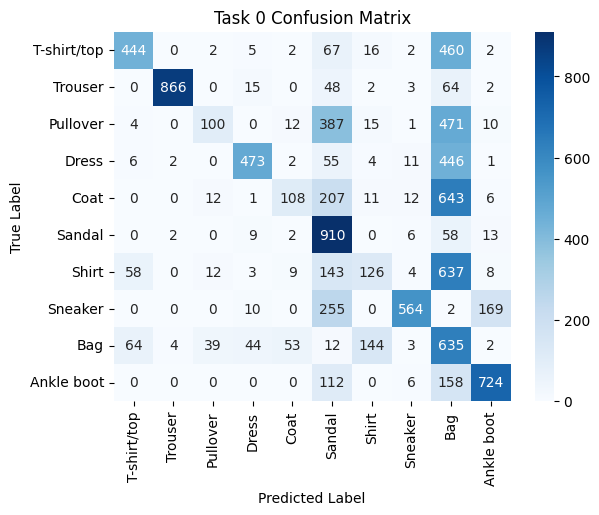

In [13]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7237
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.66      0.68      0.67      1000
     Trouser       0.90      0.92      0.91      1000
    Pullover       0.72      0.62      0.67      1000
       Dress       0.70      0.79      0.74      1000
        Coat       0.63      0.69      0.66      1000
      Sandal       0.75      0.61      0.67      1000
       Shirt       0.51      0.39      0.44      1000
     Sneaker       0.76      0.88      0.82      1000
         Bag       0.77      0.81      0.79      1000
  Ankle boot       0.78      0.85      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



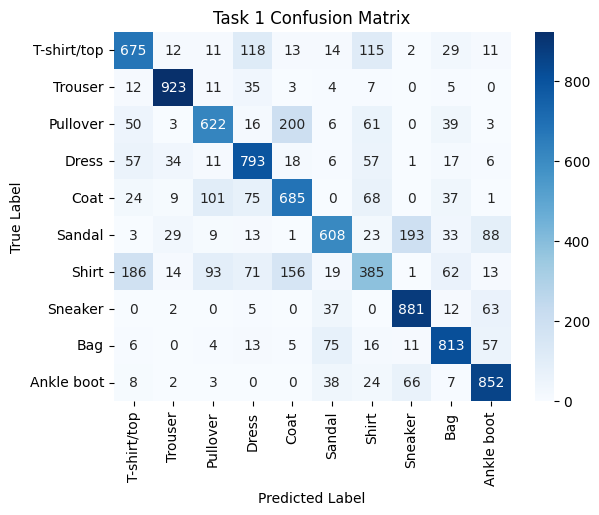

In [14]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.41839 and it's parameter diff is 0.00008
Min Parameter diff is 0.79268 and it's fisher is 0.00001
fisher > parameter diff: 565
fisher <= parameter diff: 219


<Figure size 640x480 with 0 Axes>

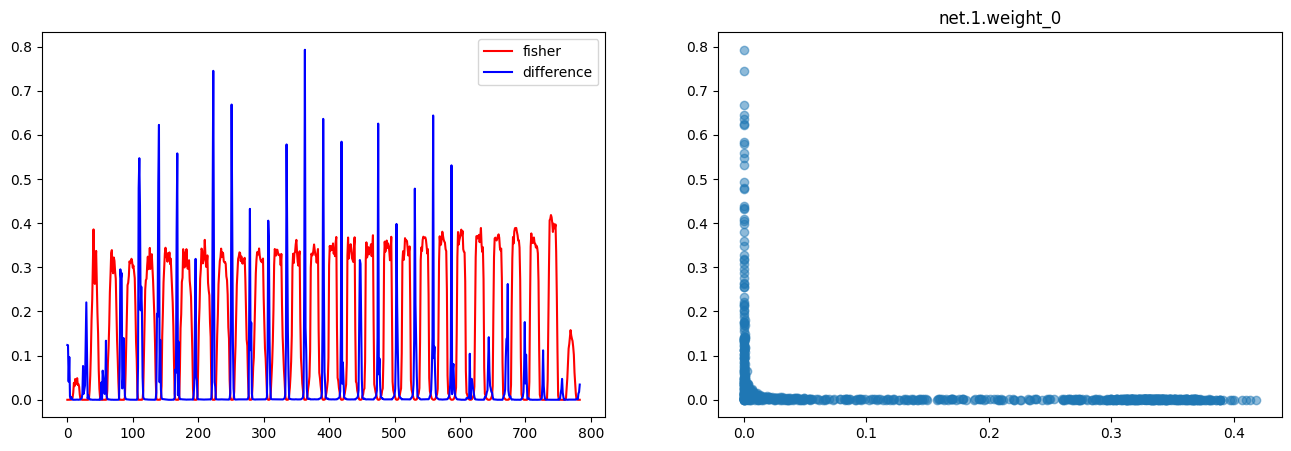

Max fisher is 0.01372 and it's parameter diff is 0.00395
Min Parameter diff is 1.18918 and it's fisher is 0.00000
fisher > parameter diff: 193
fisher <= parameter diff: 591


<Figure size 640x480 with 0 Axes>

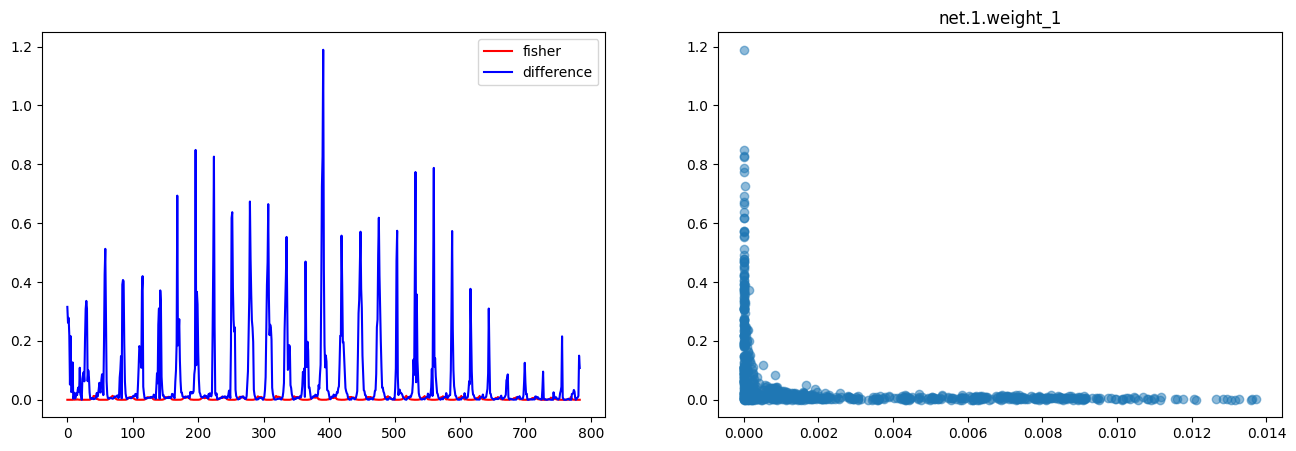

Max fisher is 0.06553 and it's parameter diff is 0.00018
Min Parameter diff is 0.78454 and it's fisher is 0.00000
fisher > parameter diff: 541
fisher <= parameter diff: 243


<Figure size 640x480 with 0 Axes>

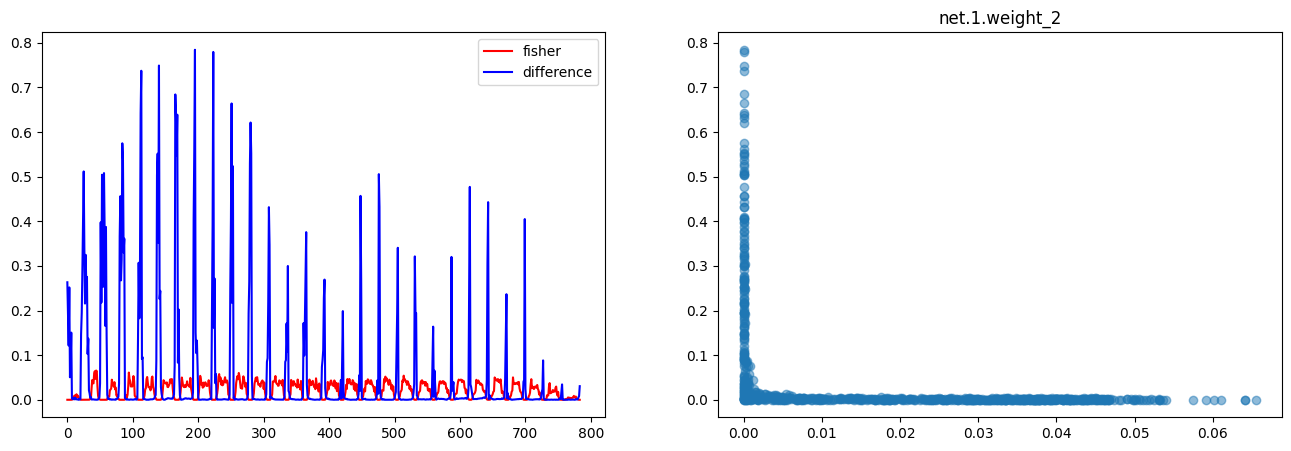

Max fisher is 0.06426 and it's parameter diff is 0.00040
Min Parameter diff is 0.75385 and it's fisher is 0.00002
fisher > parameter diff: 470
fisher <= parameter diff: 314


<Figure size 640x480 with 0 Axes>

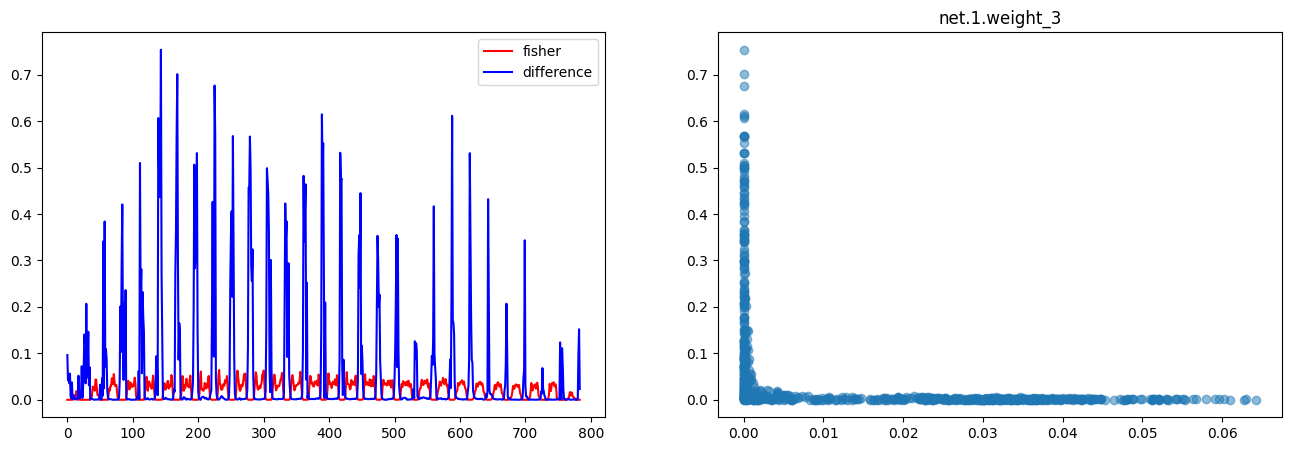

Max fisher is 0.10757 and it's parameter diff is 0.00002
Min Parameter diff is 0.76778 and it's fisher is 0.00001
fisher > parameter diff: 502
fisher <= parameter diff: 282


<Figure size 640x480 with 0 Axes>

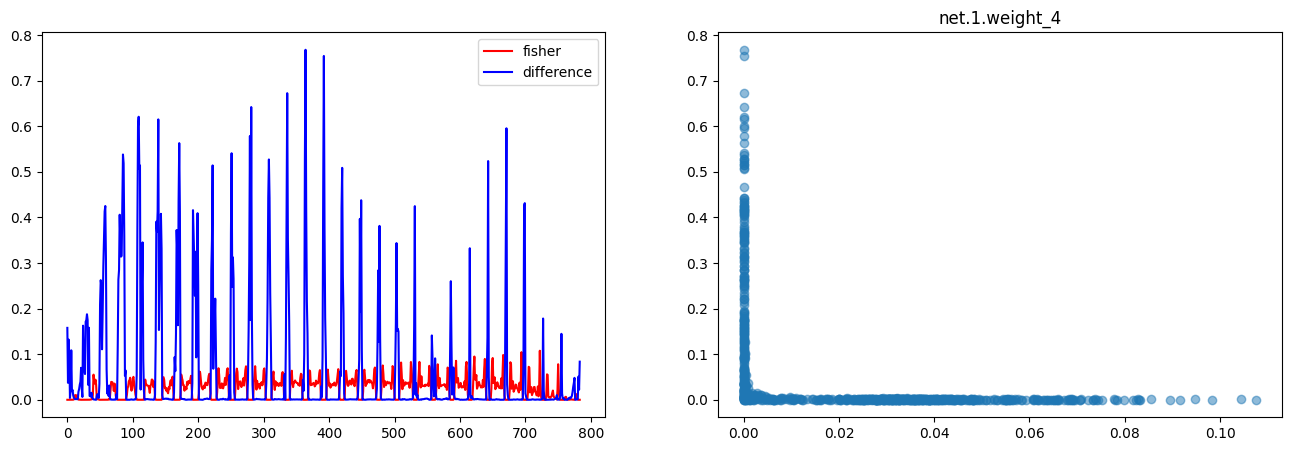

Max fisher is 0.05131 and it's parameter diff is 0.00084
Min Parameter diff is 1.16313 and it's fisher is 0.00003
fisher > parameter diff: 277
fisher <= parameter diff: 507


<Figure size 640x480 with 0 Axes>

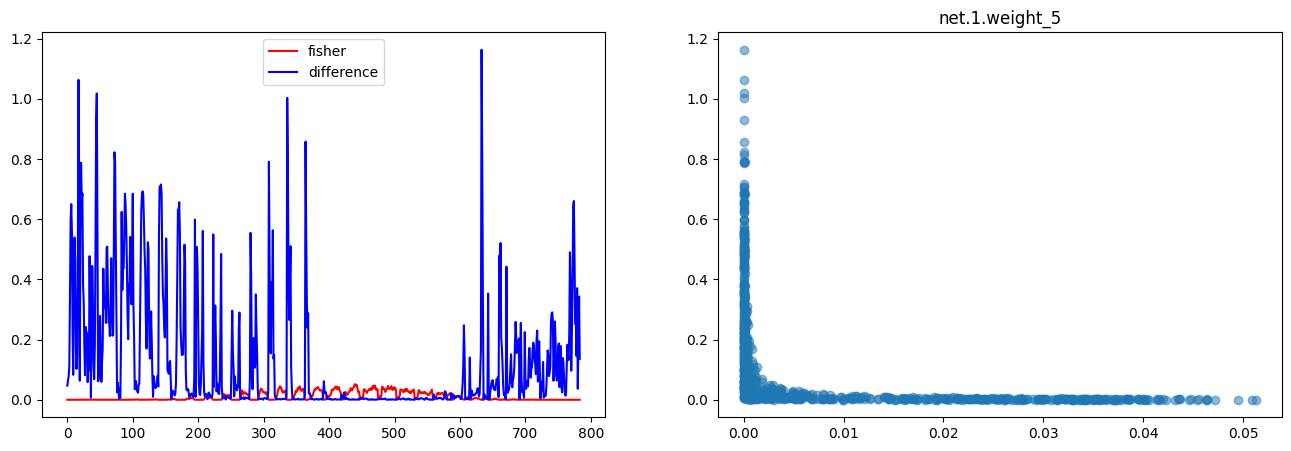

Max fisher is 0.86407 and it's parameter diff is 0.00008
Min Parameter diff is 0.79301 and it's fisher is 0.00000
fisher > parameter diff: 573
fisher <= parameter diff: 211


<Figure size 640x480 with 0 Axes>

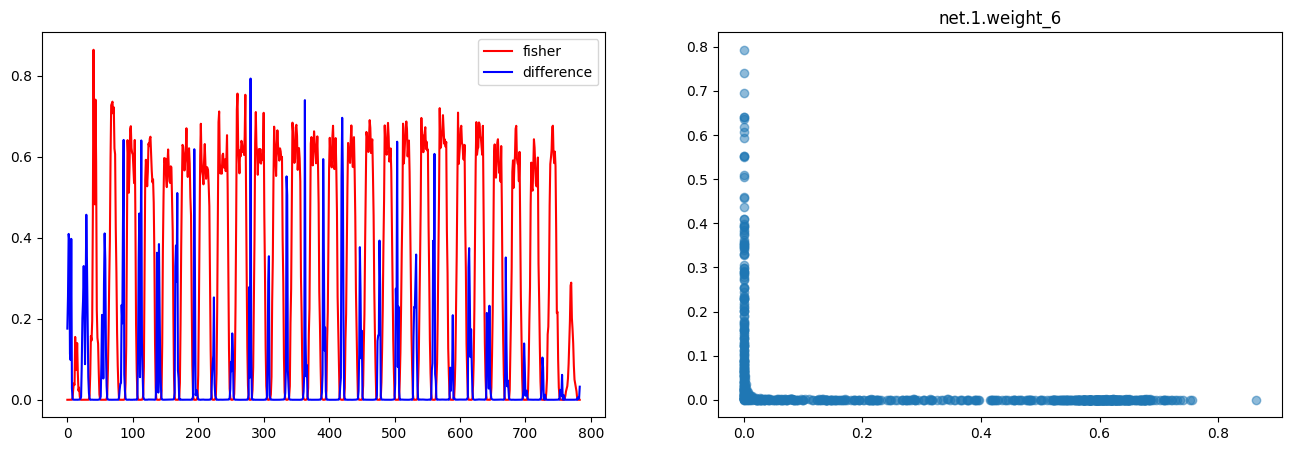

Max fisher is 0.01217 and it's parameter diff is 0.00134
Min Parameter diff is 0.95527 and it's fisher is 0.00000
fisher > parameter diff: 66
fisher <= parameter diff: 718


<Figure size 640x480 with 0 Axes>

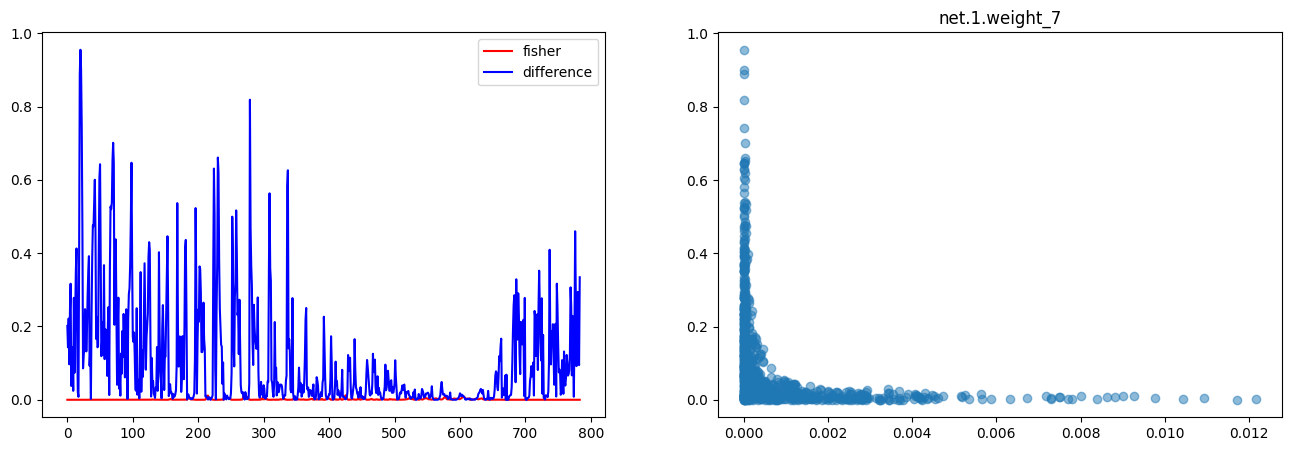

Max fisher is 0.00710 and it's parameter diff is 0.00984
Min Parameter diff is 0.97408 and it's fisher is 0.00000
fisher > parameter diff: 26
fisher <= parameter diff: 758


<Figure size 640x480 with 0 Axes>

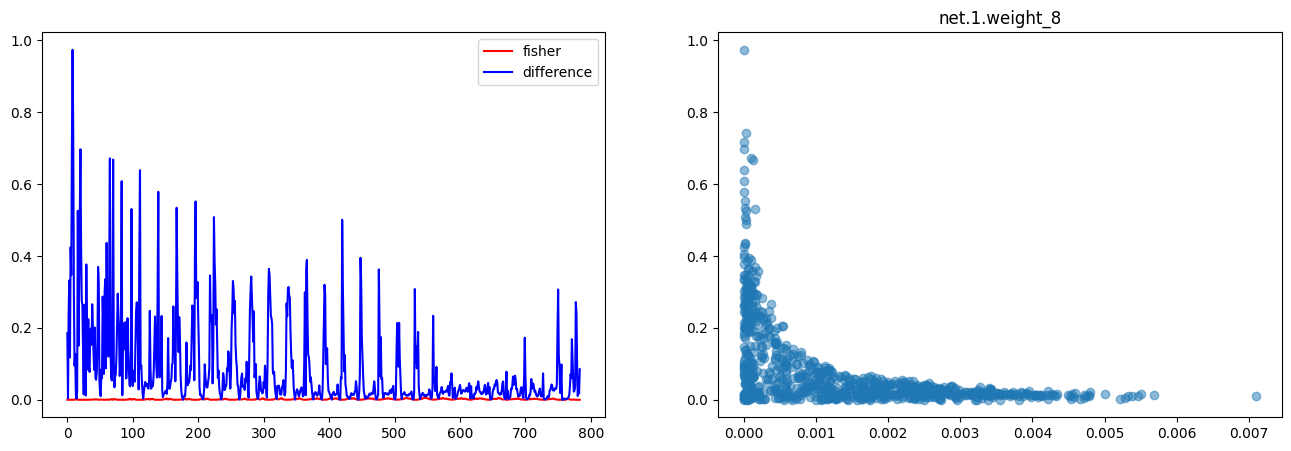

Max fisher is 0.05857 and it's parameter diff is 0.00222
Min Parameter diff is 0.92787 and it's fisher is 0.00000
fisher > parameter diff: 310
fisher <= parameter diff: 474


<Figure size 640x480 with 0 Axes>

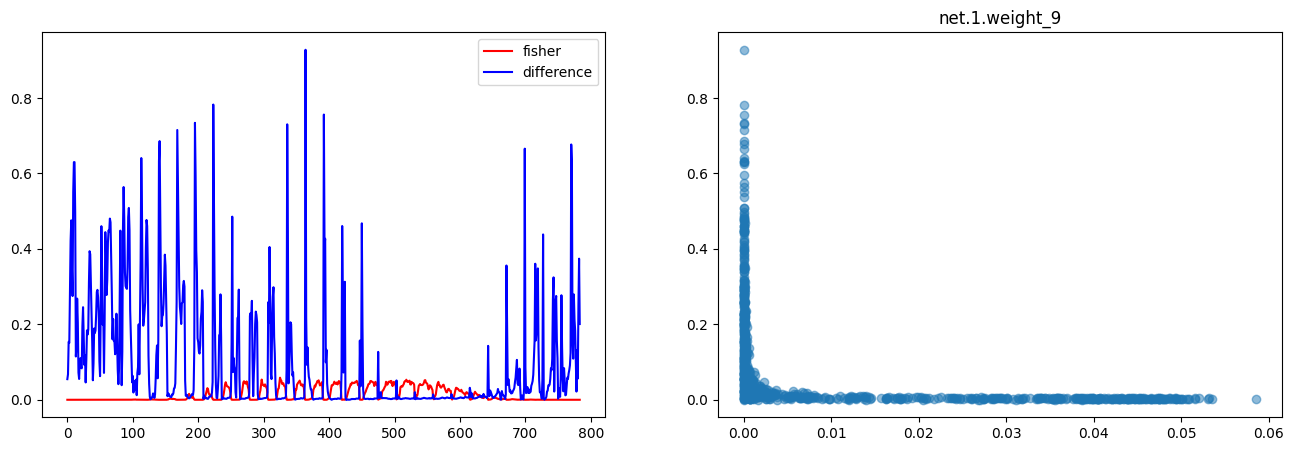


net.1.bias
torch.Size([10])
Max fisher is 1.87802 and it's parameter diff is 0.00057
Min Parameter diff is 0.04627 and it's fisher is 0.00182
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

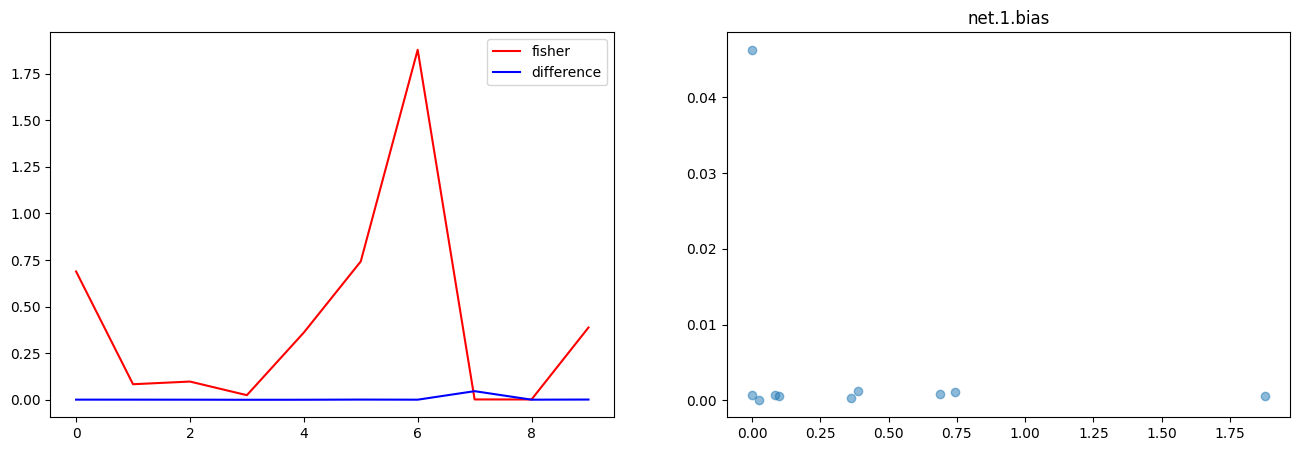

In [15]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [16]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-30_10_26_03
